# Setup

In [165]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

# Variables

In [166]:
weights = 'distance'

# Functions

In [167]:
def read_csv(filepath, cols, names):
    df = pd.read_csv(filepath, usecols=cols, names=names, header=None)
    df = df.drop([0], axis=0) # Remove first row (headers)
    df = df.astype('float64') # Cast data to floats
    
    return df

In [168]:
def read_all_csvs(path):
    files = []
    
    for file in glob.glob(path + '*/' '*.csv'):
        files.append(file)
        
    return files

In [236]:
def read_csvs(class_name, set_name):
    names = ['ax', 'ay', 'az', 'mx', 'my', 'mz']
    X = pd.DataFrame()
    y = pd.DataFrame(columns=['class'])
    
    for file in glob.glob('data/cleaned/' + set_name + '/' + class_name + '*.csv'):

        if 'acc' in file:
            mag_file = file.replace('acc', 'mag')
            
            df_acc = read_csv(file, [2,3,4], names[:3])
            df_mag = read_csv(mag_file, [2,3,4], names[3:])
            
            df = pd.concat([df_acc, df_mag], axis=1, join='inner')
            X = X.append(df, ignore_index=True)
            
            print(file + '\tLength: ', end='')
            print(len(df_acc))
            print(mag_file + '\tLength: ', end='')
            print(len(df_mag))
            #print(X)
            
    y['class'] = [class_name for i in range(len(X))]
        
    return X, y

In [170]:
def calc_norms(df):
    l = []
    
    for i in range(len(df)):
        l.append(np.linalg.norm(df.iloc[i]))
        
    return pd.DataFrame({'Norm': l})

In [171]:
def calc_angle(df, axis, i):
    return np.rad2deg(np.arccos(df[axis].iloc[i] / np.linalg.norm(df.iloc[i])))

In [172]:
def calc_angles(df, axis):
    l = []
    
    for i in range(len(df)):
        l.append(calc_angle(df, axis, i))
        
    return pd.DataFrame({'Angle': l})

In [173]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def train_knn(X, y):
    #create a dictionary of all values we want to test for n_neighbors
    param_grid = {'n_neighbors': np.arange(1, 60)}

    #use gridsearch to test all values for n_neighbors
    knn_gscv = GridSearchCV(KNeighborsClassifier(weights = weights), param_grid, cv = 5)

    #fit model to data
    knn_gscv.fit(X, y.values.ravel())

    print('Best k:\t', knn_gscv.best_params_)
    print('Score:\t', knn_gscv.best_score_)

    return knn_gscv

In [174]:
from sklearn.model_selection import cross_val_score

def plot_accuracy_of_k(X, y):
    cv_scores = []
    my_range = range(1, 60)

    for k in my_range:
        knn_cv = KNeighborsClassifier(n_neighbors = k, weights = weights)
        cv_scores.append(cross_val_score(knn_cv, X, y.values.ravel(), cv = 5, scoring='accuracy').mean())

    df_scores = pd.DataFrame(cv_scores, index = my_range)
    df_scores.plot(xlabel = 'k', ylabel = 'Accuracy', legend = False)

In [175]:
from sklearn.metrics import confusion_matrix

def print_conf_matrix(X, y, knn):
    conf_matrix = confusion_matrix(y, knn.predict(X))
    print(knn.classes_)
    print(conf_matrix)

# Read data

### Raw cleaned data

In [176]:
X_sit_train, y_sit_train = read_csvs('sit', 'train')

data/cleaned/train\sit_acc1.csv
data/cleaned/train\sit_acc1.csv	Length: 500
data/cleaned/train\sit_mag1.csv	Length: 500
data/cleaned/train\sit_acc2.csv
data/cleaned/train\sit_acc2.csv	Length: 450
data/cleaned/train\sit_mag2.csv	Length: 450
data/cleaned/train\sit_mag1.csv
data/cleaned/train\sit_mag2.csv


In [177]:
X_stand_train, y_stand_train = read_csvs('stand', 'train')

data/cleaned/train\stand_acc1.csv
data/cleaned/train\stand_acc1.csv	Length: 550
data/cleaned/train\stand_mag1.csv	Length: 550
data/cleaned/train\stand_acc2.csv
data/cleaned/train\stand_acc2.csv	Length: 500
data/cleaned/train\stand_mag2.csv	Length: 500
data/cleaned/train\stand_mag1.csv
data/cleaned/train\stand_mag2.csv


In [178]:
X_lie_train, y_lie_train = read_csvs('lie', 'train')

data/cleaned/train\lie_acc1.csv
data/cleaned/train\lie_acc1.csv	Length: 550
data/cleaned/train\lie_mag1.csv	Length: 550
data/cleaned/train\lie_acc2.csv
data/cleaned/train\lie_acc2.csv	Length: 550
data/cleaned/train\lie_mag2.csv	Length: 550
data/cleaned/train\lie_mag1.csv
data/cleaned/train\lie_mag2.csv


In [179]:
X_sit_test, y_sit_test = read_csvs('sit', 'test')

data/cleaned/test\sit_acc3.csv
data/cleaned/test\sit_acc3.csv	Length: 450
data/cleaned/test\sit_mag3.csv	Length: 450
data/cleaned/test\sit_mag3.csv


In [180]:
X_stand_test, y_stand_test = read_csvs('stand', 'test')

data/cleaned/test\stand_acc3.csv
data/cleaned/test\stand_acc3.csv	Length: 600
data/cleaned/test\stand_mag3.csv	Length: 600
data/cleaned/test\stand_mag3.csv


In [181]:
X_lie_test, y_lie_test = read_csvs('lie', 'test')

data/cleaned/test\lie_acc3.csv
data/cleaned/test\lie_acc3.csv	Length: 550
data/cleaned/test\lie_mag3.csv	Length: 550
data/cleaned/test\lie_mag3.csv


In [182]:
X_train = pd.concat([X_sit_train, X_stand_train, X_lie_train], ignore_index=True)
y_train = pd.concat([y_sit_train, y_stand_train, y_lie_train], ignore_index=True)

In [183]:
X_test = pd.concat([X_sit_test, X_stand_test, X_lie_test], ignore_index=True)
y_test = pd.concat([y_sit_test, y_stand_test, y_lie_test], ignore_index=True)

### Transformed raw cleaned data (norms and angles)

In [184]:
X_train_acc_norms = calc_norms(X_train[['ax','ay','az']])
X_train_acc_norms.rename(columns={'Norm': 'Acc norm'}, inplace=True)

X_test_acc_norms = calc_norms(X_test[['ax','ay','az']])
X_test_acc_norms.rename(columns={'Norm': 'Acc norm'}, inplace=True)

In [185]:
X_train_mag_norms = calc_norms(X_train[['mx','my','mz']])
X_train_mag_norms.rename(columns={'Norm': 'Mag norm'}, inplace=True)

X_test_mag_norms = calc_norms(X_test[['mx','my','mz']])
X_test_mag_norms.rename(columns={'Norm': 'Mag norm'}, inplace=True)

In [186]:
X_train_acc_angles = calc_angles(X_train[['ax','ay','az']], X_train.columns[2])
X_train_acc_angles.rename(columns={'Angle': 'Acc z angle'}, inplace=True)

X_test_acc_angles = calc_angles(X_test[['ax','ay','az']], X_train.columns[2])
X_test_acc_angles.rename(columns={'Angle': 'Acc z angle'}, inplace=True)

In [187]:
X_train_mag_angles = calc_angles(X_train[['mx','my','mz']], X_train.columns[4])
X_train_mag_angles.rename(columns={'Angle': 'Mag y angle'}, inplace=True)

X_test_mag_angles = calc_angles(X_test[['mx','my','mz']], X_train.columns[4])
X_test_mag_angles.rename(columns={'Angle': 'Mag y angle'}, inplace=True)

In [188]:
X_train_transformed = pd.concat([X_train_acc_norms, X_train_mag_norms, X_train_acc_angles, X_train_mag_angles], axis = 1)
X_test_transformed = pd.concat([X_test_acc_norms, X_test_mag_norms, X_test_acc_angles, X_test_mag_angles], axis = 1)

# Tasks

#### The iris set is evaluated in a separate file: lab2_iris.ipynb

## KNN once again with your own recorded data

#### 1. Should you use the standard scaler or not when you work with the data? You need to motivate your answer and explain why

If only accelerometer values are used no scaling is required since the are already to the same scale.<p>
If both accelerometer and magnetometer values are used scaling might be required as the magnetometer values generally are larger.

In [189]:
X_train.describe()

,ax,ay,az,mx,my,mz
count,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000,3100.000000
mean,1.467447,-4.312653,5.186234,-31.870930,22.152321,-15.236801
std,3.178907,3.635546,4.976354,17.411648,22.519195,14.456745
min,-2.589932,-9.559626,-2.177170,-59.325000,-3.300000,-38.568752
25%,-1.598405,-9.288938,-1.489831,-51.956253,4.326562,-26.325000
50%,0.623629,-2.394916,7.432406,-30.665627,10.593750,-16.987500
75%,4.994120,-1.197010,9.704391,-13.837501,52.331253,0.675000
max,6.625427,-1.055833,9.934401,-7.106250,55.631252,6.881250


#### 2. Train the KNN classifier with your training data (cross validation!) Choose the k value that is optimal. You should present the result accuracy as a function of k. Present the confusion matrix and explain the result.

As seen below no scaling was required using all features - the model predicted all instances correctly.

In [190]:
knn_all_features = train_knn(X_train, y_train)

Best k:	 {'n_neighbors': 1}
Score:	 1.0


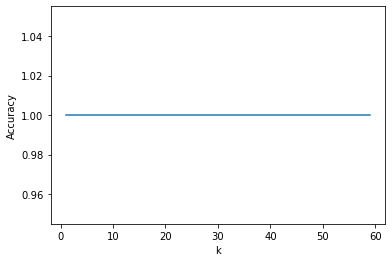

In [191]:
plot_accuracy_of_k(X_train, y_train)

In [192]:
print_conf_matrix(X_train, y_train, knn_all_features)

['lie' 'sit' 'stand']
[[1100    0    0]
 [   0  950    0]
 [   0    0 1050]]


#### 3. Test the KNN classifier with the optimal k using the test data set. Present the accuracy and confusion matrix. Explain the result and compare it with the training set.

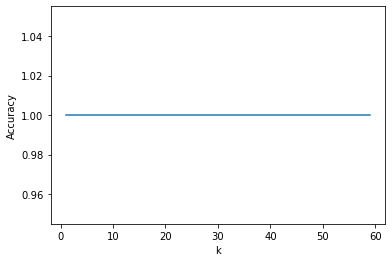

In [193]:
plot_accuracy_of_k(X_test, y_test)

In [194]:
knn_all_features.best_score_

1.0

In [195]:
print_conf_matrix(X_test, y_test, knn_all_features)

['lie' 'sit' 'stand']
[[550   0   0]
 [  0 450   0]
 [  0   0 600]]


#### 4. Redo point 2 and 3 but only use feature 1-3. Compare with the result in 3 with point 3 above.

In [196]:
knn_acc = train_knn(X_train[['ax', 'ay', 'az']], y_train)

Best k:	 {'n_neighbors': 1}
Score:	 1.0


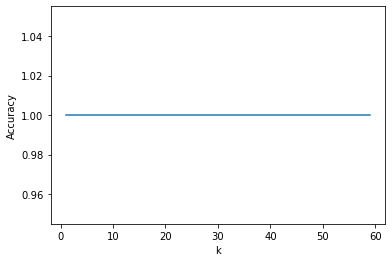

In [197]:
plot_accuracy_of_k(X_train[['ax', 'ay', 'az']], y_train)

In [198]:
print_conf_matrix(X_train[['ax', 'ay', 'az']], y_train, knn_acc)

['lie' 'sit' 'stand']
[[1100    0    0]
 [   0  950    0]
 [   0    0 1050]]


In [199]:
print_conf_matrix(X_test[['ax', 'ay', 'az']], y_test, knn_acc)

['lie' 'sit' 'stand']
[[550   0   0]
 [  0 450   0]
 [  0   0 600]]


#### 5. Redo point 2 and 3 but only use feature 4-6. Compare with the result in 3 with point 3 above.

In [200]:
knn_mag = train_knn(X_train[['mx', 'my', 'mz']], y_train)

Best k:	 {'n_neighbors': 1}
Score:	 1.0


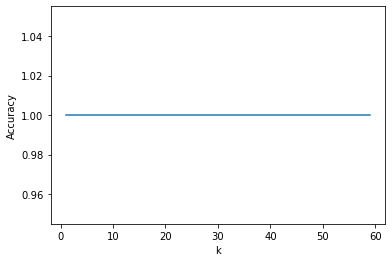

In [201]:
plot_accuracy_of_k(X_train[['mx', 'my', 'mz']], y_train)

In [202]:
print_conf_matrix(X_train[['mx', 'my', 'mz']], y_train, knn_mag)

['lie' 'sit' 'stand']
[[1100    0    0]
 [   0  950    0]
 [   0    0 1050]]


In [203]:
print_conf_matrix(X_test[['mx', 'my', 'mz']], y_test, knn_mag)

['lie' 'sit' 'stand']
[[550   0   0]
 [  0 450   0]
 [  0   0 600]]


## KNN– with transformed recorded data

#### 1. Should you use the standard scaler or not when you work with the data? You need to motivate your answer and explain why

As the mean and standard deviation differs a lot between the different features it would be a good idea to normalize the values.

In [204]:
X_train_transformed.describe()

,Acc norm,Mag norm,Acc z angle,Mag y angle
count,3100.000000,3100.000000,3100.000000,3100.000000
mean,9.783076,52.173951,49.461041,59.386752
std,0.109822,5.956530,38.071181,33.797538
min,9.562847,40.294631,7.017520,7.762446
25%,9.697532,46.333894,11.877947,15.435632
50%,9.734550,54.224304,39.733953,79.665962
75%,9.907119,57.570239,98.827421,84.208110
max,10.019783,61.572334,103.006665,94.038231


#### 2. Train the KNN classifier with your training data (cross validation!) Choose the k value that is optimal. You should present the result accuracy as a function of k. Present the confusion matrix and explain the result.

As seen below no scaling was required using all features - the model predicted all instances correctly.

In [205]:
knn_all_transformed_features = train_knn(X_train_transformed, y_train)

Best k:	 {'n_neighbors': 1}
Score:	 1.0


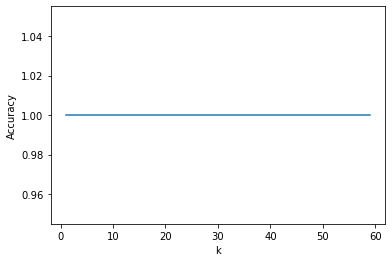

In [206]:
plot_accuracy_of_k(X_train_transformed, y_train)

In [207]:
print_conf_matrix(X_train_transformed, y_train, knn_all_transformed_features)

['lie' 'sit' 'stand']
[[1100    0    0]
 [   0  950    0]
 [   0    0 1050]]


#### 3. Test the KNN classifier with the optimal k using the test data set. Present the accuracy and confusion matrix. Explain the result and compare it with the training set.

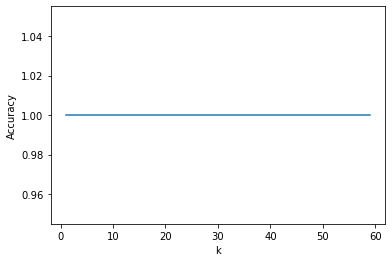

In [208]:
plot_accuracy_of_k(X_test_transformed, y_test)

In [209]:
knn_all_transformed_features.best_score_

1.0

In [210]:
print_conf_matrix(X_test_transformed, y_test, knn_all_transformed_features)

['lie' 'sit' 'stand']
[[550   0   0]
 [  0 450   0]
 [  0   0 600]]


#### 4. Redo point 2 and 3 but only use feature 1-2. Compare with the result in 3 with point 3 above.

Two features will give 100%.

In [211]:
knn_acc_transformed = train_knn(X_train_transformed[['Acc norm']], y_train)

Best k:	 {'n_neighbors': 56}
Score:	 0.6996774193548386


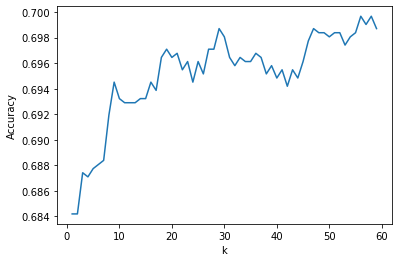

In [212]:
plot_accuracy_of_k(X_train_transformed[['Acc norm']], y_train)

In [213]:
print_conf_matrix(X_train_transformed[['Acc norm']], y_train, knn_acc_transformed)

['lie' 'sit' 'stand']
[[1100    0    0]
 [   0  950    0]
 [   0    0 1050]]


In [214]:
print_conf_matrix(X_test_transformed[['Acc norm']], y_test, knn_acc_transformed)

['lie' 'sit' 'stand']
[[538   8   4]
 [  0 208 242]
 [  0 207 393]]


#### 5. Redo point 2 and 3 but only use feature 3-4. Compare with the result in 3 with point 3 above.

In [215]:
knn_mag_transformed = train_knn(X_train_transformed[['Mag norm', 'Mag y angle']], y_train)

Best k:	 {'n_neighbors': 1}
Score:	 1.0


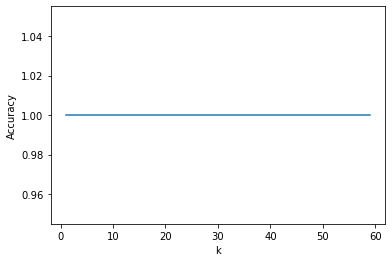

In [216]:
plot_accuracy_of_k(X_train_transformed[['Mag norm', 'Mag y angle']], y_train)

In [217]:
print_conf_matrix(X_train_transformed[['Mag norm', 'Mag y angle']], y_train, knn_mag_transformed)

['lie' 'sit' 'stand']
[[1100    0    0]
 [   0  950    0]
 [   0    0 1050]]


In [218]:
print_conf_matrix(X_test_transformed[['Mag norm', 'Mag y angle']], y_test, knn_mag_transformed)

['lie' 'sit' 'stand']
[[550   0   0]
 [  0 450   0]
 [  0   0 600]]


## KNN – with four classes

Record new data:

* sit - stand
* stand - sit
* lie - sit
* lie - stand
* ...

### Read data

In [245]:
X_sit_to_stand_train, y_sit_to_stand_train = read_csvs('sit_to_stand', 'train')
X_sit_to_stand_test, y_sit_to_stand_test = read_csvs('sit_to_stand', 'test')

data/cleaned/train\sit_to_stand_acc1.csv	Length: 423
data/cleaned/train\sit_to_stand_mag1.csv	Length: 430
data/cleaned/train\sit_to_stand_acc2.csv	Length: 387
data/cleaned/train\sit_to_stand_mag2.csv	Length: 392
data/cleaned/test\sit_to_stand_acc3.csv	Length: 375
data/cleaned/test\sit_to_stand_mag3.csv	Length: 381


In [246]:
X_stand_to_sit_train, y_stand_to_sit_train = read_csvs('stand_to_sit', 'train')
X_stand_to_sit_test, y_stand_to_sit_test = read_csvs('stand_to_sit', 'test')

data/cleaned/train\stand_to_sit_acc1.csv	Length: 305
data/cleaned/train\stand_to_sit_mag1.csv	Length: 311
data/cleaned/train\stand_to_sit_acc2.csv	Length: 304
data/cleaned/train\stand_to_sit_mag2.csv	Length: 310
data/cleaned/test\stand_to_sit_acc3.csv	Length: 322
data/cleaned/test\stand_to_sit_mag3.csv	Length: 328


In [254]:
X_train = pd.concat([X_sit_train, X_stand_train, X_lie_train, X_sit_to_stand_train, X_stand_to_sit_train], ignore_index=True)
y_train = pd.concat([y_sit_train, y_stand_train, y_lie_train, y_sit_to_stand_train, y_stand_to_sit_train], ignore_index=True)
X_test = pd.concat([X_sit_test, X_stand_test, X_lie_test, X_sit_to_stand_test, X_stand_to_sit_test], ignore_index=True)
y_test = pd.concat([y_sit_test, y_stand_test, y_lie_test, y_sit_to_stand_test, y_stand_to_sit_test], ignore_index=True)

#### 1. Should you use the standard scaler or not when you work with the data? You need to motivate your answer and explain why

#### 2. Train the KNN classifier with your training data (cross validation!) Choose the k value that is optimal. You should present the result accuracy as a function of k. Present the confusion matrix and explain the result.

In [255]:
knn_all_features = train_knn(X_train, y_train)

Best k:	 {'n_neighbors': 6}
Score:	 0.9227626201746391


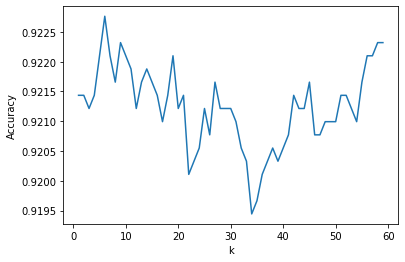

In [256]:
plot_accuracy_of_k(X_train, y_train)

In [257]:
print_conf_matrix(X_train, y_train, knn_all_features)

['lie' 'sit' 'sit_to_stand' 'stand' 'stand_to_sit']
[[1100    0    0    0    0]
 [   0  950    0    0    0]
 [   0    0  810    0    0]
 [   0    0    0 1050    0]
 [   0    0    0    0  609]]


#### 3. Test the KNN classifier with the optimal k using the test data set. Present the accuracy and confusion matrix. Explain the result and compare it with the training set.

In [286]:
print_conf_matrix(X_test, y_test, knn_all_features)

['lie' 'sit' 'sit_to_stand' 'stand' 'stand_to_sit']
[[550   0   0   0   0]
 [  0 450   0   0   0]
 [  0   0 349   0  26]
 [  0   0   0 600   0]
 [  0   0  29   0 293]]


In [298]:
df_stand_to_sit = entire_training_set[entire_training_set['class'] == 'stand_to_sit']
df_sit_to_stand = entire_training_set[entire_training_set['class'] == 'sit_to_stand']
df_move = df_stand_to_sit.append(df_sit_to_stand)

,ax,ay,az,mx,my,mz,class
3910,-1.135992,-10.340583,3.222235,19.106250,20.793750,-15.712501,stand_to_sit
3911,-0.702293,-10.321441,2.300101,19.687500,20.437500,-16.706251,stand_to_sit
3912,-0.508176,-9.303294,0.469891,19.368752,22.106250,-17.381250,stand_to_sit
3913,-0.580260,-9.140582,0.908076,19.425001,20.193750,-17.493752,stand_to_sit
3914,-0.740579,-9.430413,1.698605,19.350000,20.887500,-17.512500,stand_to_sit
...,...,...,...,...,...,...,...
3905,-1.248455,-9.492626,0.536890,23.981250,25.631250,-18.450000,sit_to_stand
3906,-1.248455,-9.492626,0.536890,24.712502,24.337502,-16.650002,sit_to_stand
3907,-1.013659,-9.914362,0.335593,24.956251,24.712502,-15.525001,sit_to_stand
3908,-1.013659,-9.914362,0.335593,24.956251,24.712502,-15.525001,sit_to_stand


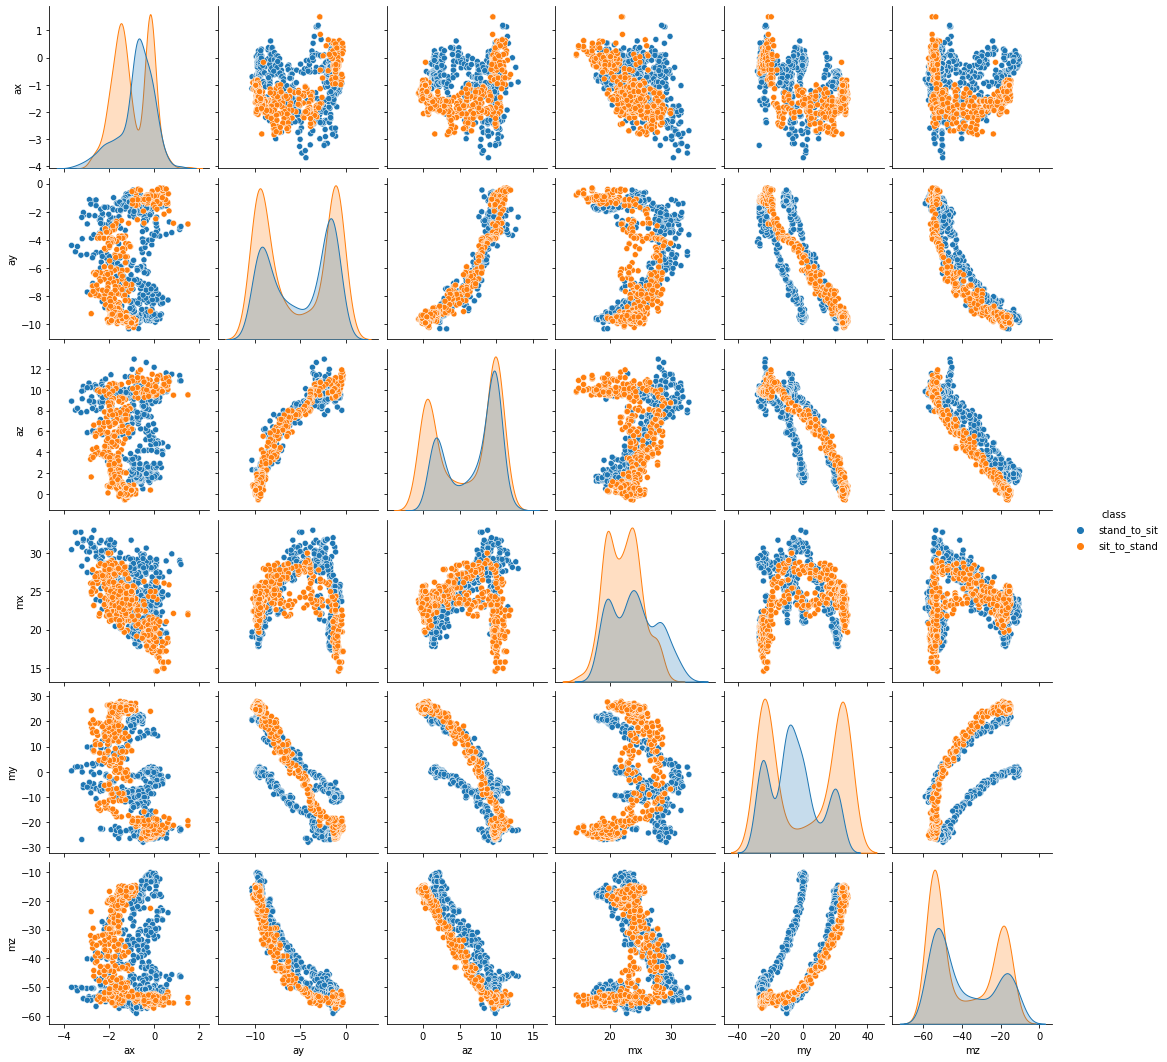

In [299]:
sns.pairplot(df_move, hue = 'class')